In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn


# Own functions
from dataloaders import Dataset_CTCovid19August2020, Dataset_PolyU_CXR
import transforms
import blocks
import pytorch_msssim
import losses
import pix2pix

# Flags:
flag_debug = False
flag_train_intermediate_network = False # Do we train the generator beforehand?
flag_retrain_intermediate_network = False # if the generator was trained beforehand, do we retrain it?

# Input directories
#DRR_directory = "D:\data\CT-Covid-19-August2020\DRR_output"
#CXR_directory = "D:\data\POLYU_COVID19_CXR_CT_Cohort1"
DRR_directory = "G:\DanielLam\CT-Covid-19-August2020\DRR_output"
CXR_directory = "G:\DanielLam\POLYU_COVID19_CXR_CT_Cohort1"

# Save directories
output_save_directory = Path("./runs/pix2pix_boneless_LSadversarial_test/")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_G = os.path.join(output_save_directory, "netG.pt") # path to save weights for generator
PATH_D = os.path.join(output_save_directory, "netD.pt") # path to save weights for discriminator
PATH_G_int1 = os.path.join(output_save_directory, "netG_int1.pt")

# Proportion training vs validation
proportion_validation = 0.1
randomisation_seed = 42

# Pre-training
num_epochs_generator_pretraining = 100

# Settings for training:
num_epochs_generator = 200 # Isola et al. Image-to-Image Translation with CGANs
_batch_size = 32 # 1 per GPU at least
discriminator_keys_images = ["source", "boneless", "lung"]
generator_keys_images = ["source"]
generator_target = "boneless"
image_spatial_size = (256,256)

# Adam Optimiser
# Pretraining
lr_pretraining = 0.001 # Gusarev
beta1_pretraining = 0.9
beta2_pretraining = 0.999

# Discriminator
lr_D = 0.0002

# Generator
# Parameters from: Isola et al. 2016 Image-to-Image Translation
lr_G = 0.0002
beta1=0.5
beta2=0.999

reg_L1 = 100

# Optimizer scheduling
num_epochs_decay = num_epochs_generator - 100
def lambda_rule(epoch, num_epochs_ini_lr=100, current_epoch=0, num_epochs_decay=num_epochs_decay):
    lr_l = 1.0 - max(0, epoch + current_epoch - num_epochs_ini_lr) / float(num_epochs_decay + 1)
    return lr_l


# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0., 0.02)
        #nn.init.kaiming_normal_(m.weight.data, a=0.2, nonlinearity='leaky_relu')
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

# Techniques for improved training
# Label Smoothing
random.seed(0)
flip_rate_threshold = 0.05 # for this, 0.25 means 25% of the time, real and fake labels are flipped.

# Decide which device we want to run on
ngpu = 2
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"
print(device)
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

cuda


In [2]:
# Set up datasets and dataloaders
ds_training = Dataset_CTCovid19August2020(os.path.join(DRR_directory,"DRR_directory.csv"), 
                                               os.path.join(DRR_directory), 
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, discriminator_keys_images, "PixelSize"),
                                     transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                                     transforms.Random180(discriminator_keys_images, probability=0.5),
                                     transforms.IntensityJitter(discriminator_keys_images,source_image_key="source", rescale_factor_limits=(0.75,1.0), window_motion_limits=(-1,1)),
                                     transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                                     transforms.RandomRotation(discriminator_keys_images),
                                     transforms.ToTensor(discriminator_keys_images),
                                     ]))

ds_testing = Dataset_PolyU_CXR(Path(CXR_directory),
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, generator_keys_images, "PixelSize"),
                                     transforms.ImageComplement(generator_keys_images),
                                     transforms.RescalingNormalisation(generator_keys_images,(0,1)),
                                     transforms.ToTensor(generator_keys_images),
                                     ]))

# Training and Validation Set
lengths = [math.ceil(len(ds_training)*proportion_validation), math.floor(len(ds_training) - len(ds_training)*proportion_validation)]
ds_val, ds_training = random_split(ds_training, lengths, generator=torch.Generator().manual_seed(randomisation_seed))


dl_training = DataLoader(ds_training, batch_size=_batch_size,
                         shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=_batch_size,
                    shuffle=True, num_workers=0)

# Test set
dl_testing = DataLoader(ds_testing, batch_size=_batch_size,
                        shuffle=True, num_workers=0)

torch.Size([32, 1, 256, 256])
tensor(0.0538)


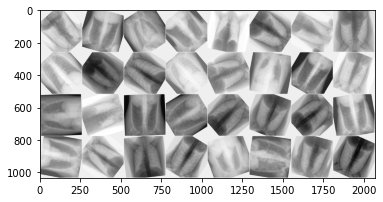

In [3]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
print(sample["source"].shape)
# create grid of images
img_grid = vutils.make_grid(sample["source"])
# show images

matplotlib_imshow(img_grid, one_channel=True)

msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1)
msssim_loss = 1 - msssim(sample[generator_target], sample["source"])
print(msssim_loss)

In [4]:
## Implementation of Network 
# Network Structure
_input_array_shape_classifier = (_batch_size, 2 , image_spatial_size[0], image_spatial_size[1])  # 2 channels -- channel 0 for source, channel 1 for real/fake boneless
_input_array_shape_generator = (_batch_size, 1 , image_spatial_size[0], image_spatial_size[1])

"""
netG = blocks.Generator_ResUNet_modified(_input_array_shape_generator, _first_out_channels=64,
                                _reluType="leaky", _dropoutType="ADL", _drop_rate=0.75, _output_activation="Tanh")

netG = blocks.Generator_ResUNet_PixelShuffle(input_array_shape=_input_array_shape_generator,
                                             _first_out_channels=64,
                                             _reluType="leaky", _dropoutType="ADL", _drop_rate=0.5,
                                             _output_activation="Tanh")
netG = blocks.Generator_ResUNet_A(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_generator,
                                  _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)
netD = blocks.MultiScale_Classifier(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_classifier,
                                    _classifier_out_channels=64,
                                    _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)
"""

netG = pix2pix.UnetGenerator(input_nc=_input_array_shape_generator[1], output_nc=_input_array_shape_generator[1],
                             num_downs=8, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=True)
netD = pix2pix.Discriminator_Pix2Pix(_input_array_size = _input_array_shape_classifier, spectral_normalize=False)

# Initialise weights
netG.apply(weights_init)
netD.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

netG = netG.to(device)
netD = netD.to(device)

# Fixed Test Sample
fixed_test_image = next(iter(dl_testing))


In [5]:
# Training loop for Generator first
import pytorch_msssim
if (flag_retrain_intermediate_network or not(os.path.isfile(PATH_G_int1))) and flag_train_intermediate_network:
    print("Training intermediate network...")
    # Optimiser
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_pretraining, betas=(beta1_pretraining, beta2_pretraining))
    
    # Loss
    def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
        mseloss = nn.MSELoss() # L2 used for easier optimisation
        
        msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize="relu")
        msssim_loss = 1 - msssim(testImage, referenceImage)
        total_loss = (1-alpha)*mseloss(testImage, referenceImage) + alpha*msssim_loss
        return total_loss
    # MSSSIM
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize="relu")
    # Data Input
    img_list_pretraining = []
    accuracy_list_pretraining = []
    iters=0
    print("Beginning Training...")
    for epoch in range(num_epochs_generator_pretraining):
        # For each batch in the dataloader
        for i, data in enumerate(dl_training):
            # Save a training image
            if iters == 0:
                fixed_training_image = data['source']
            ##############################
            # Match NetG output to the ground-truth
            ##############################
            netG.zero_grad()
            noisy_data = data['source'].to(device)
            fake = netG(noisy_data)
            loss = criterion_Gusarev(fake, data[generator_target].to(device))
            loss.backward() # calculate gradients
            optimizerG.step() # optimiser step along gradients
            
            # Output training stats
            if i % 200 == 0:
                print('[%d/%d][%d/%d]\tLoss_G: %.4f'
                      % (epoch, num_epochs_generator_pretraining, i, len(dl_training),
                         loss.item()))
            # Record generator output
            if (iters % 100 == 0) or ((epoch == num_epochs_generator_pretraining-1) and (i == len(dl_training)-1)):
                with torch.no_grad():
                    fake = netG(fixed_training_image).detach().cpu()
                img_list_pretraining.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1
        # Per epoch, evaluate model on validation data
        netG.eval()
        with torch.no_grad():
            dataiter_val = iter(dl_val)
            val_sample = dataiter_val.next()
            val_source = val_sample["source"].to(device)
            val_output = netG(val_source).cpu()
            # Calculate loss of val_output v.s. the actual desired output
            pixel_distance = msssim(val_output, val_sample[generator_target])
            print('[%d/%d]\tMS-SSIM: %.4f'
                      % (epoch, num_epochs_generator_pretraining, pixel_distance))
            accuracy_list_pretraining.append(pixel_distance)
        netG.train()
    # SAVE FINAL NETG        
    torch.save(netG.state_dict(), PATH_G_int1)
    
elif not(flag_retrain_intermediate_network) and os.path.isfile(PATH_G_int1):
    # If not retraining, load the network into netG
    print("Loading Saved Pre-trained State.")
    netG.load_state_dict(torch.load(PATH_G_int1))
else:
    print("No pre-training.")

No pre-training.


tensor(1.0000),tensor(0.)


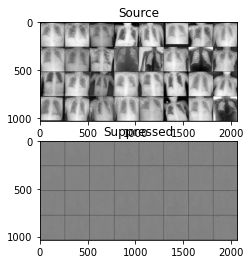

In [6]:
# INFERENCE OUTPUTS
if flag_train_intermediate_network:
    netG.load_state_dict(torch.load(PATH_G_int1))

# Fixed Test Sample
fixed_test_image = next(iter(dl_testing))
fixed_training_image = next(iter(dl_training))

with torch.no_grad():
    input_image = fixed_test_image['source'] #fixed_test_image['source']
    input_images = vutils.make_grid(input_image, padding=2, normalize=True)
    output_image = netG(input_image).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)

print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))

fig, ax = plt.subplots(2,1)
ax[0].imshow(np.transpose(input_images, (1,2,0)))
ax[0].set_title("Source")
ax[1].imshow(np.transpose(output_images, (1,2,0)))
ax[1].set_title("Suppressed")
plt.show
if not flag_debug and flag_train_intermediate_network:
    fig.savefig(os.path.join(output_save_directory, current_date + "pretraining"+".png"))

if flag_train_intermediate_network:
    # Pixel Distance
    plt.figure(figsize=(10,5))
    plt.title("Pixel Distance between source and "+generator_target)
    plt.plot(accuracy_list_pretraining)
    plt.xlabel("Epochs")
    plt.ylabel("MS-SSIM")
    if not flag_debug:
        plt.savefig(os.path.join(output_save_directory, current_date + "pretraining_accuracy"+".png"))
    plt.show()

    # Animation
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_pretraining]
    ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
    if not flag_debug:
        ani.save(os.path.join(output_save_directory, current_date+"pretraining_output.mp4"), dpi=300)

In [7]:
## Training Loop for GAN
import losses
from torch.optim import lr_scheduler

# Helper Functions
def set_requires_grad(nets, requires_grad=False):
    """https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/f13aab8148bd5f15b9eb47b690496df8dadbab0c/models/base_model.py#L219
    Set requires_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad
    return net

# Loss Functions
adversarial_loss = nn.BCEWithLogitsLoss()
# IF USING BCEWithLogitsLoss, do NOT use Sigmoid as output activation for Discriminator
msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize="relu")

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))
optimizerG.zero_grad()
optimizerD.zero_grad()

schedulerD = lr_scheduler.LambdaLR(optimizerD, lr_lambda=lambda_rule)
schedulerG = lr_scheduler.LambdaLR(optimizerG, lr_lambda=lambda_rule)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_G_z1_list = []
D_G_z2_list = []
D_x_list = []
accuracy_list = []
iters = 0
reals_shown = []
reals_shown_now = 0
print("Beginning Training...")
if flag_train_intermediate_network:
    netG.load_state_dict(torch.load(PATH_G_int1))
# For each epoch
torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs_generator):
    # For each batch in the dataloader
    schedulerD.step()
    schedulerG.step()
    for i, data in enumerate(dl_training):
        
        ############################
        # Labels
        ############################
        # Label Smoothing as mentioned by Salimans et al. 2016 Improved Techniques for Training GANs
        real_label = 1. #random.uniform(0.7,1.0) 
        fake_label = 0. #random.uniform(0.0,0.3)
        
        # Label flipping to cripple discriminator
        flip_probability = random.uniform(0.,1.)
        fake_label_original = fake_label
        real_label_original = real_label
        if flip_probability < flip_rate_threshold:
            fake_label = real_label_original
            real_label = fake_label_original
        
        fake_label = torch.tensor(fake_label)
        real_label = torch.tensor(real_label)
        ###########################
        # (0) Generate fake image batch with G
        ###########################
        conditioning_data = data['source'].to(device)
        fake = netG(conditioning_data)    

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Train with all-real batch
        netD = set_requires_grad(netD, True)
        optimizerD.zero_grad()
        
        ## REAL DATA
        real_data = torch.cat((data['source'].to(device), data[generator_target].to(device)), dim=1)
        # Forward pass real batch through D and flatten
        pred_real = netD(real_data)
        label_real = real_label.expand_as(pred_real).to(device)
        # Calculate loss on all-real batch
        #print(pred_real)
        #print(label_real)
        errD_real = adversarial_loss(pred_real, label_real)
        
        
        ## FAKE DATA
        fake_data = torch.cat((data['source'].to(device) , fake), dim=1)
        # Fake is detached because the .backwards() command destroys parts of the computational graph
        pred_fake = netD(fake_data.detach())
        label_fake = fake_label.expand_as(pred_fake).to(device)
        # Calculate loss on the all-fake batch
        errD_fake = adversarial_loss(pred_fake, label_fake)
        
        # Calculate the gradients for this batch together
        errD = (errD_fake + errD_real)*0.5
        errD.backward()
        
        # Update D
        optimizerD.step()
        
        D_x = pred_real.mean().item()
        D_G_z1 = pred_fake.mean().item() 
        
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netD = set_requires_grad(netD, False)
        optimizerG.zero_grad()
        real_label = torch.tensor(real_label_original) # only flip for discriminator
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # fake CANNOT be detached here.
        fake_data = torch.cat((data['source'].to(device), fake), dim=1)
        pred_fake = netD(fake_data)
        label_real = real_label.expand_as(pred_fake).to(device)  # fake labels are real for generator cost
        # Calculate G's loss based on this output
        errG = adversarial_loss(pred_fake, label_real) + reg_L1*losses.criterion_L1Loss(fake.detach(), data[generator_target].detach().to(device))
        # Calculate gradients for G and update optimizer
        errG.backward()
        optimizerG.step()
        
        D_G_z2 = pred_fake.mean().item()
        
        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x,z): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs_generator, i, len(dl_training),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_G_z1_list.append(D_G_z1)
        D_G_z2_list.append(D_G_z2)
        D_x_list.append(D_x)
        
        # Check how the generator is doing by saving G's output on a fixed test image
        if (iters % 100 == 0) or ((epoch == num_epochs_generator-1) and (i == len(dl_training)-1)):
            with torch.no_grad():
                fake = netG(fixed_test_image['source'][0:1,:,:,:]).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1
        reals_shown_now += _batch_size
        reals_shown.append(reals_shown_now)
        if flag_debug and i == 2:
            print(iters)
            print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
            break
    # Per epoch, evaluate model on validation data
    netG.eval()
    with torch.no_grad():
        dataiter_val = iter(dl_val)
        val_sample = dataiter_val.next()
        val_source = val_sample["source"].to(device)
        val_output = netG(val_source).cpu()
        # Calculate loss of val_output v.s. the actual desired output
        
        pixel_distance = msssim(val_output, val_sample[generator_target])
        print('[%d/%d]\tMS-SSIM: %.4f'
                  % (epoch, num_epochs_generator, pixel_distance))
        accuracy_list.append(pixel_distance)
    netG.train()
    
    if flag_debug and epoch == 2:
        print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
        break

# SAVE WEIGHTS
if not flag_debug:
    torch.save(netG.state_dict(), PATH_G)
    torch.save(netD.state_dict(), PATH_D)


Beginning Training...


C:\Users\Y1112\anaconda3\envs\daniel\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\Users\Y1112\anaconda3\envs\daniel\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


[0/200][0/19]	Loss_D: 1.5838	Loss_G: 63.3807	D(x,z): -0.1292	D(G(z)): -0.1056 / 0.2189
[0/200]	MS-SSIM: 0.1149
[1/200][0/19]	Loss_D: 0.9016	Loss_G: 46.9625	D(x,z): 0.6561	D(G(z)): 0.2943 / 0.3114
[1/200]	MS-SSIM: 0.1519
[2/200][0/19]	Loss_D: 0.4173	Loss_G: 44.8583	D(x,z): 0.6420	D(G(z)): 0.3399 / 0.3656
[2/200]	MS-SSIM: 0.1925
[3/200][0/19]	Loss_D: 0.5342	Loss_G: 48.5516	D(x,z): 0.8081	D(G(z)): 0.2881 / 0.2173
[3/200]	MS-SSIM: 0.2322
[4/200][0/19]	Loss_D: 0.1498	Loss_G: 37.6587	D(x,z): 0.7414	D(G(z)): 0.2449 / 0.2006
[4/200]	MS-SSIM: 0.2772
[5/200][0/19]	Loss_D: 0.2836	Loss_G: 35.8590	D(x,z): 0.7087	D(G(z)): 0.1742 / 0.2341
[5/200]	MS-SSIM: 0.4217
[6/200][0/19]	Loss_D: 0.1200	Loss_G: 32.1263	D(x,z): 0.7109	D(G(z)): 0.2408 / 0.2396
[6/200]	MS-SSIM: 0.6724
[7/200][0/19]	Loss_D: 0.1506	Loss_G: 26.0066	D(x,z): 0.7024	D(G(z)): 0.3045 / 0.2407
[7/200]	MS-SSIM: 0.7455
[8/200][0/19]	Loss_D: 0.2710	Loss_G: 17.7340	D(x,z): 0.4930	D(G(z)): 0.4477 / 0.4424
[8/200]	MS-SSIM: 0.6639
[9/200][0/19]	Los

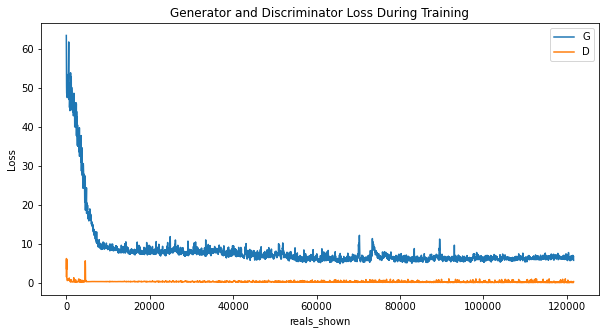

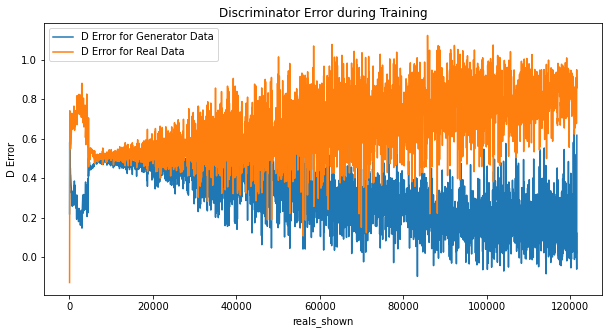

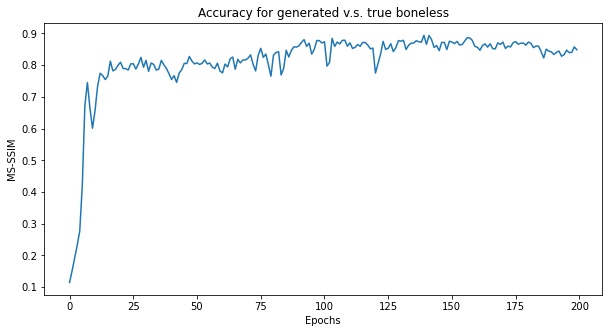

torch.Size([3, 256, 256])
tensor(1.0000),tensor(0.)


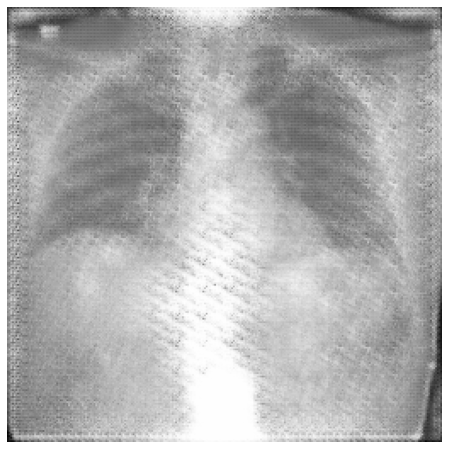

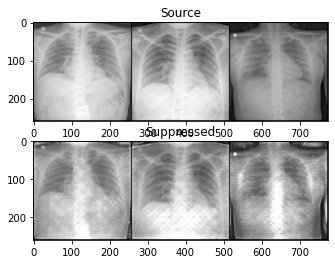

In [8]:
# Inference

# Plot G and D loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(reals_shown, G_losses,label="G")
plt.plot(reals_shown, D_losses,label="D")
plt.xlabel("reals_shown")
plt.ylabel("Loss")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))
plt.show()
# Plot D errors
plt.figure(figsize=(10,5))
plt.title("Discriminator Error during Training")
plt.plot(reals_shown, D_G_z2_list,label="D Error for Generator Data")
plt.plot(reals_shown, D_x_list,label="D Error for Real Data")
plt.xlabel("reals_shown")
plt.ylabel("D Error")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "D_errors"+".png"))
plt.show()

# Plot Pixel Distance at each Epoch
plt.figure(figsize=(10,5))
plt.title("Accuracy for generated v.s. true "+generator_target)
plt.plot(accuracy_list)
plt.xlabel("Epochs")
plt.ylabel("MS-SSIM")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "accuracy"+".png"))
plt.show()

# ANIMATED VALIDATION IMAGE
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
print(img_list[0].shape)
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"generator_output.mp4"), dpi=300)

# TEST CXR IMAGES
with torch.no_grad():
    input_image = fixed_test_image['source'] #fixed_test_image['source']
    input_images = vutils.make_grid(input_image[0:3,:,:,:], padding=2, normalize=True)
    output_image = netG(input_image[0:3,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)

print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))

fig, ax = plt.subplots(2,1)
ax[0].imshow(np.transpose(input_images, (1,2,0)))
ax[0].set_title("Source")
ax[1].imshow(np.transpose(output_images, (1,2,0)))
ax[1].set_title("Suppressed")
plt.show
if not flag_debug:
    fig.savefig(os.path.join(output_save_directory, current_date + "afterGenerator"+".png"))

In [9]:


"""# TENSORBOARD Visualisation
writer = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))

# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
print(sample['source'].shape)
# create grid of images
img_grid = vutils.make_grid(sample['source'])

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('Images', img_grid)

writer.add_graph(netG, sample['source'])
writer.close()

%load_ext tensorboard
%tensorboard --logdir runs"""

"# TENSORBOARD Visualisation\nwriter = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))\n\n# get some random training images\ndataiter = iter(dl_training)\nsample = dataiter.next()\nprint(sample['source'].shape)\n# create grid of images\nimg_grid = vutils.make_grid(sample['source'])\n\n# show images\nmatplotlib_imshow(img_grid, one_channel=True)\n\n# write to tensorboard\nwriter.add_image('Images', img_grid)\n\nwriter.add_graph(netG, sample['source'])\nwriter.close()\n\n%load_ext tensorboard\n%tensorboard --logdir runs"

In [10]:
not(os.path.isfile(PATH_G_int1))

True